# Compute SNR of signal with and without gaps

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from astropy import units as u
import pandas as pd

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
Tobs = 1  # [years]
dt = 50.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
p0 = 8.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"

response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        t0 = 100000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=True,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

In [8]:
chans_few_local = td_gen(
    *emri_waveform_args,
    **emri_waveform_kwargs,
)

# Generate a waveform
start = time.time()
chans_tdi_local = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 2.16 s


## Compare with signal on cluster

In [9]:
filename='signal.npz'

In [10]:
def load_signal_data(filename=filename):
    # Load the file
    data = np.load(filename)
    
    # Extract data (dimensions are automatically preserved!)
    result = {
        'dt': data['dt'].item() if data['dt'].shape == () else data['dt'],
        'chans_few': data['chans_few'],
        'chans_tdi': data['chans_tdi'],
    }
    
    # Close the file
    data.close()
    
    return result

In [11]:
# Load the data
data = load_signal_data('signal.npz')

# Access the values
dt_gpu = data['dt']
chans_few_gpu = data['chans_few']
chans_tdi_gpu = data['chans_tdi']

print(f"dt: {dt_gpu}")
print(f"chans_few_gpu: {chans_few_gpu} (length: {len(chans_few_gpu)})")
print(f"chans_tdi_gpu: {chans_tdi_gpu} (length: {len(chans_tdi_gpu)})")

dt: 50.0
chans_few_gpu: [-2.21606056e-23+1.67993344e-22j -9.18669852e-23+1.12227980e-22j
 -1.16716655e-22+5.09275972e-23j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j] (length: 631163)
chans_tdi_gpu: [[-6.91886899e-25 -1.64108469e-24 -3.98683977e-24 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.76257546e-24 -2.31997378e-24 -1.87774105e-24 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] (length: 2)


## Look at the signals

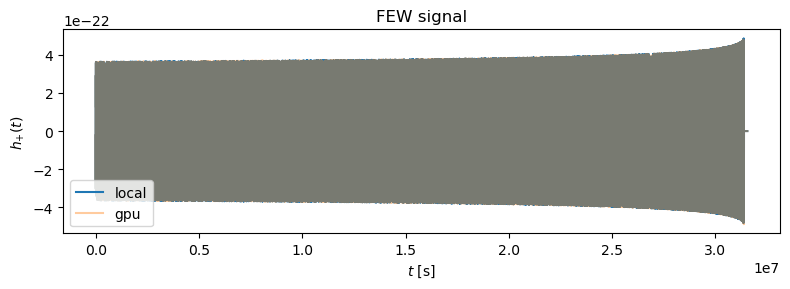

In [12]:
# Visualise the signal
time_array = np.arange(0,len(chans_few_local.real))*dt
time_array_gpu = np.arange(0,len(chans_few_gpu.real))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans_few_local.real, label='local')
plt.plot(time_array_gpu, chans_few_gpu.real, alpha=0.4, label='gpu')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.title('FEW signal')
plt.legend()
plt.tight_layout()

plt.show()

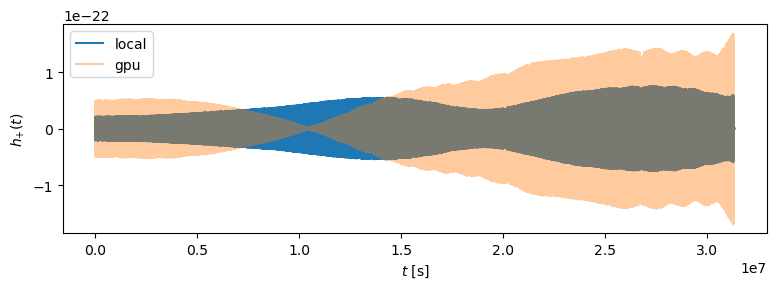

In [13]:
# Visualise the signal
time_array = np.arange(0,len(chans_tdi_local[0]))*dt
time_array_gpu = np.arange(0,len(chans_tdi_gpu[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans_tdi_local[0], label='local')
plt.plot(time_array_gpu, chans_tdi_gpu[0], alpha=0.4, label='gpu')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()